<center><H1> Mini Project - Feature Engineering </H1></center><br/>
<center><H2> Student Id: 2021AIML049 &  2021AIML064 </H2></center><br/>
<center><H2> Student Names: Deepa Krishnaswami &  Jagadish Yalla </H2></center><br/>
<center><H2> Swiggy Rating Prediction </H2></center><br/>


In [1]:
# Importing some libraries to begin with

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from datetime import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [2]:
# Load the data set

Swiggyto = pd.read_csv('Food_Orders.csv')

<center><h1>Section 1: Data Quality </h1></center>

In [3]:
# let's inspect the first 5 rows of the 1st data set
Swiggyto.head()

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating
0,1.0,NaN,1-July-2020 8.38 PM,3.0,Delivered,300,PRO,1-July-2020 9.38 PM,50.0,NaN,COD,20,NaN,10,5,NaN,Y,PANEER;ROTI,BING,VEG,2.0
1,2.0,NaN,1-July-2020 8.38 AM,3.0,Delivered,100,BF,1-July-2020 8.58 AM,NaN,NaN,WALLET,20,NaN,10,5,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0
2,3.0,NaN,1-July-2020 9.00 PM,6.0,Cancelled,250,PRO,1-July-2020 9.30 PM,25.0,NaN,CARD,25,10,10,5,5.0,Y,MIXVEG;RICE,BING,VEG,0.0
3,4.0,NaN,1-July-2020 7.30 PM,4.0,Delivered,550,PRO,1-July-2020 9.05 PM,NaN,NaN,COD,25,10,10,5,NaN,N,CHICKEN;BIRYANI,NO,MIX,1.0
4,423.0,NaN,1-July-2020 8.38 PM,3.0,Cancelled,125,PRO,1-July-2020 7.38 PM,NaN,NaN,COD,20,NaN,10,5,NaN,Y,DAL;ROTI,NO,VEG,1.0


# Section 1: Data Quality
## missing values check

In [4]:
# Getting column information
Swiggyto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 58 non-null     float64
 1   Provider           0 non-null      float64
 2   DateTime           60 non-null     object 
 3   Distance           59 non-null     float64
 4   Status             59 non-null     object 
 5   Cost               60 non-null     object 
 6   PromoCode          36 non-null     object 
 7   Delivery Time      59 non-null     object 
 8   Discount           24 non-null     float64
 9   Paid amount        1 non-null      float64
 10  Payment mode       59 non-null     object 
 11  Delivery charges   60 non-null     object 
 12  Surge charges      28 non-null     object 
 13  Packaging charges  60 non-null     object 
 14  ST                 60 non-null     object 
 15  Tip                24 non-null     float64
 16  PureVeg            59 non-nu

<center><h2>Data Integrity Quick Notes </h2></center>

**1. Provider has 0 non-null values - best to drop it - this is done in section 2 on data transformation**       
**2. Paid amount has only 1 non null value - again - best to drop the column - this is done in later sections**         
**3. Datetime and delivery time should have date-time format but have object type - this is done in data transformation section   
4. All Payment or cost related variabbles should be in float type - some of them are object type - this is done in data trans section**


In [5]:
# Inspect other columns for null values
Swiggyto.isnull().sum()

ID                    2
Provider             60
DateTime              0
Distance              1
Status                1
Cost                  0
PromoCode            24
Delivery Time         1
Discount             36
Paid amount          59
Payment mode          1
Delivery charges      0
Surge charges        32
Packaging charges     0
ST                    0
Tip                  36
PureVeg               1
Items                 1
Membership            1
Type                  1
Rating                3
dtype: int64

###                    Observations and solutions for treatment as per rubric and general logic

***
****1. ID has 2 null values, these will be replaced with some unique values              
 2. Distance has 1 null value - this can be replaced with mean                   
 3. Status has one null value - this can be replaced with mode                   
 4. Promocode has 24 null values - so it looks like "missing promor code"can be a useful category - its NMAR - so replace with new category                                   
 5. Delivery time has 1 null        
 6. Discount - has 36 null - we assume discount is zero if missing                           
 7. Payment mode has 36 missing - replace with mode                          
 8. Surge charges have 32 missing - replace with zero as per rubric        
 9. Tip has 36 missing - replace with zero - assuming missing tip means zero tip     
 10. Pureveg, membership - missing values are replaced by mode                       
 11. Items missing value is not treated, since we cannot impute items on our own for now. Later items column will be used to create new data and we will deal with the null value there.      
 11. Type replace with mode       
 12. Rating replace with mean of ratings column  *****


### Duplicate Record Issue: 
#### Next, we will do a column by column data integrity check and an overall data check too, before replacing the missing values


In [6]:
# Check One - Duplicates across the data set assuming ID (Which is assumed to be orderID is the primary key)
unique_recs = Swiggyto.groupby(['ID']).count().reset_index().rename(columns={"DateTime":"Mentions"})
unique_recs.shape

(56, 21)

In [7]:
# According to the shape, unique records are 56 only. These are non null records.
# Since we have 60 total records, we have to understand there are 2 sets of duplicates in the rest of the 4 records
# To find the exact places where duplicates occur
Swiggyto.groupby(['ID'])['ID'].count()

ID
1.0      1
2.0      1
3.0      1
4.0      1
5.0      2
6.0      1
7.0      1
8.0      1
9.0      1
10.0     1
11.0     2
12.0     1
13.0     1
14.0     1
15.0     1
16.0     1
17.0     1
18.0     1
19.0     1
20.0     1
21.0     1
22.0     1
23.0     1
24.0     1
25.0     1
26.0     1
27.0     1
28.0     1
29.0     1
30.0     1
31.0     1
32.0     1
33.0     1
34.0     1
35.0     1
36.0     1
37.0     1
38.0     1
39.0     1
40.0     1
41.0     1
42.0     1
43.0     1
44.0     1
45.0     1
46.0     1
47.0     1
48.0     1
49.0     1
50.0     1
51.0     1
56.0     1
310.0    1
423.0    1
456.0    1
467.0    1
Name: ID, dtype: int64

In [8]:
# Clearly from the table above, ID 5 has freq count of 2 and so has ID 11
# Lets check the full record corrosponding to ID 5 and ID 11 to understand which record to retain and if there is true duplication
unique_recs.sort_values(by=['Mentions'], inplace=True, ascending=False)
unique_recs.head(5)

,ID,Provider,Mentions,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating
4,5.0,0,2,2,2,2,2,2,0,0,2,2,0,2,2,0,2,2,2,2,2
10,11.0,0,2,2,2,2,0,2,2,0,2,2,0,2,2,0,2,2,2,2,2
0,1.0,0,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1
42,43.0,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1
31,32.0,0,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,1


In [9]:
# To figure out how to deal with the 4 data rows for this, lets list all of them to see how the columns compare
# Begin with ID =5

Swiggyto[Swiggyto.ID.isin([5])]

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating
5,5.0,NaN,1-July-2020 8.38 PM,3.0,Cancelled,125,PRO,1-July-2020 8.38 PM,NaN,NaN,COD,20,NaN,10,5,NaN,Y,DAL;ROTI,NO,VEG,1.0
15,5.0,NaN,1-July-2020 8.38 PM,3.0,Cancelled,125,PRO,1-July-2020 8.38 PM,NaN,NaN,COD,20,NaN,10,5,NaN,Y,DAL;ROTI,NO,VEG,1.0


In [10]:
# Clearly for ID 5, both rows are exact same for all remaining 17 cols, so can drop one of them
# Checking for ID is 11

Swiggyto[Swiggyto.ID.isin([11])]

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating
11,11.0,NaN,2-July-2020 8.38 PM,3.0,Delivered,500,NaN,2-July-2020 9.38 PM,50.0,NaN,WALLET,20,NaN,10,5,NaN,Y,PANEER;ROTI,BING,VEG,4.0
54,11.0,NaN,2-July-2020 8.38 PM,3.0,Delivered,500,NaN,2-July-2020 9.38 PM,50.0,NaN,WALLET,20,NaN,10,5,NaN,Y,PANEER;ROTI,BING,VEG,4.0


In [11]:
# Similarly, for ID 11, both rows are exactly same for all 17 columns, so can drop one of them

### Imputing null values for ID column

**We also know null values for 2 rows exists. So cannot drop duplicates on ID, before treating those, else one of them will get dropped too                     
Before dropping duplicates, lets impute the missing value for the 2 rows with a ID -99,    
-99 is randomly chosen value that does not exist in the ID col.     
The same -99 is used for now, since we dont expect to use the ID column for modelling        
We will use the combination of ID and DateTime columns as primary key for de-duplication of the dataset**

In [12]:
Swiggyto.isnull().sum()

ID                    2
Provider             60
DateTime              0
Distance              1
Status                1
Cost                  0
PromoCode            24
Delivery Time         1
Discount             36
Paid amount          59
Payment mode          1
Delivery charges      0
Surge charges        32
Packaging charges     0
ST                    0
Tip                  36
PureVeg               1
Items                 1
Membership            1
Type                  1
Rating                3
dtype: int64

In [13]:
# Flagging rows with missing ID
Swiggyto["ID"].fillna(-99, inplace = True) 

In [14]:
Swiggyto.isnull().sum()

ID                    0
Provider             60
DateTime              0
Distance              1
Status                1
Cost                  0
PromoCode            24
Delivery Time         1
Discount             36
Paid amount          59
Payment mode          1
Delivery charges      0
Surge charges        32
Packaging charges     0
ST                    0
Tip                  36
PureVeg               1
Items                 1
Membership            1
Type                  1
Rating                3
dtype: int64

In [15]:
Swiggyto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 60 non-null     float64
 1   Provider           0 non-null      float64
 2   DateTime           60 non-null     object 
 3   Distance           59 non-null     float64
 4   Status             59 non-null     object 
 5   Cost               60 non-null     object 
 6   PromoCode          36 non-null     object 
 7   Delivery Time      59 non-null     object 
 8   Discount           24 non-null     float64
 9   Paid amount        1 non-null      float64
 10  Payment mode       59 non-null     object 
 11  Delivery charges   60 non-null     object 
 12  Surge charges      28 non-null     object 
 13  Packaging charges  60 non-null     object 
 14  ST                 60 non-null     object 
 15  Tip                24 non-null     float64
 16  PureVeg            59 non-nu

In [16]:
Swiggyto[Swiggyto.ID.isin([-99])]

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating
18,-99.0,NaN,2-July-2020 9.38 AM,3.0,Delivered,300,NaN,2-July-2020 9.58 AM,50.0,NaN,WALLET,20,NaN,10,5,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,3.0
23,-99.0,NaN,3-July-2020 8.38 PM,NaN,NaN,COD,20,NaN,10.0,5.0,NaN,Y,DAL;ROTI,NO,VEG,2.0,NaN,NaN,NaN,NaN,NaN


In [17]:
# Dropping duplicates on the column ID & Datetime combination
swiggy = Swiggyto.drop_duplicates(subset=['ID','DateTime'])
swiggy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 59
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 58 non-null     float64
 1   Provider           0 non-null      float64
 2   DateTime           58 non-null     object 
 3   Distance           57 non-null     float64
 4   Status             57 non-null     object 
 5   Cost               58 non-null     object 
 6   PromoCode          35 non-null     object 
 7   Delivery Time      57 non-null     object 
 8   Discount           23 non-null     float64
 9   Paid amount        1 non-null      float64
 10  Payment mode       57 non-null     object 
 11  Delivery charges   58 non-null     object 
 12  Surge charges      28 non-null     object 
 13  Packaging charges  58 non-null     object 
 14  ST                 58 non-null     object 
 15  Tip                24 non-null     float64
 16  PureVeg            57 non-nu

## Imputing Missing target label using mean 

In [18]:
# Replace missing Rating with mean of the Ratings
mean_value_Rating =swiggy['Rating'].mean()
print('Mean of values in column Rating:')
print(mean_value_Rating)

Mean of values in column Rating:
2.4


In [19]:
swiggy.groupby(['Rating'])['ID'].count()

Rating
0.0    14
1.0     5
2.0     5
3.0    15
4.0     8
5.0     8
Name: ID, dtype: int64

In [20]:
# Replace missing Rating with mean of the Ratings
swiggy['Rating'].fillna((swiggy['Rating'].mean()), inplace=True)

C:\Users\JAGADISH\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [21]:
# Check Rating column freq
swiggy.groupby(['Rating'])['ID'].count()
# Clearly as we see , 3 missing values have been replaced with column mean of 2.4

Rating
0.0    14
1.0     5
2.0     5
2.4     3
3.0    15
4.0     8
5.0     8
Name: ID, dtype: int64

In [22]:
swiggy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 59
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 58 non-null     float64
 1   Provider           0 non-null      float64
 2   DateTime           58 non-null     object 
 3   Distance           57 non-null     float64
 4   Status             57 non-null     object 
 5   Cost               58 non-null     object 
 6   PromoCode          35 non-null     object 
 7   Delivery Time      57 non-null     object 
 8   Discount           23 non-null     float64
 9   Paid amount        1 non-null      float64
 10  Payment mode       57 non-null     object 
 11  Delivery charges   58 non-null     object 
 12  Surge charges      28 non-null     object 
 13  Packaging charges  58 non-null     object 
 14  ST                 58 non-null     object 
 15  Tip                24 non-null     float64
 16  PureVeg            57 non-nu

## Data Integrity 
### Fixing Data integrity and missing values column by column

**Negative distance,  Replace with positive    
rating check - zero value acceptable 	  
negative discount, repalce with positivr values**

In [23]:
# Checking Distance column for data integrity issues

swiggy.groupby(['Distance'])['ID'].count()

Distance
-2.0     1
 3.0    36
 4.0    10
 6.0    10
Name: ID, dtype: int64

In [24]:
# replacing the value of  Distance (-2) with Distance = 2 - Fix of data integrity issue
swiggy.Distance = swiggy.Distance.replace(to_replace= -2, value= 2, regex=True)

C:\Users\JAGADISH\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [25]:
swiggy.groupby(['Distance'])['ID'].count()

Distance
2.0     1
3.0    36
4.0    10
6.0    10
Name: ID, dtype: int64

In [26]:
# Check for colum discount
swiggy.groupby(['Discount'])['ID'].count()

Discount
-25.0     1
 10.0     1
 25.0    11
 50.0    10
Name: ID, dtype: int64

In [27]:
# replacing the value of  Distance (-25) with Distance = 25 - Fix of data integrity issue
swiggy.Discount = swiggy.Discount.replace(to_replace= -25, value= 25, regex=True)

In [28]:
swiggy.groupby(['Discount'])['ID'].count()

Discount
10.0     1
25.0    12
50.0    10
Name: ID, dtype: int64

### Now that Data Integrity Issues are solved for, lets focus on imputing missing values

**** Our Approach is                                  
discount  - replace with zero                    
delivery charges - replace with zero       
surge charges - replace with zero           
packaging charges - replace with zero         
tip - replace with zero                       
order id - replace with some unique value or drop it             
promo code - - replace with new category****


In [29]:
# Before fixing missing values, convert all these numeric values into a suitable format
# numeric variables that are currently of object type are delivery charges, surge changes, packaging charges

swiggy['Delivery charges'] = pd.to_numeric(swiggy['Delivery charges'],errors = 'coerce')
swiggy['Surge charges'] = pd.to_numeric(swiggy['Surge charges'],errors = 'coerce')
swiggy['Packaging charges'] = pd.to_numeric(swiggy['Packaging charges'],errors = 'coerce')

# This also has the benefit of dropping non-numeric string values in these columns that are illogical.

<ipython-input-29-a4a93c17eab6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Delivery charges'] = pd.to_numeric(swiggy['Delivery charges'],errors = 'coerce')
<ipython-input-29-a4a93c17eab6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Surge charges'] = pd.to_numeric(swiggy['Surge charges'],errors = 'coerce')
<ipython-input-29-a4a93c17eab6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [30]:
swiggy.groupby(['Delivery charges'])['ID'].count()

Delivery charges
20.0    37
25.0    20
Name: ID, dtype: int64

In [31]:
swiggy["Discount"].fillna(0, inplace = True) 
swiggy.groupby(['Discount'])['ID'].count()

Discount
0.0     35
10.0     1
25.0    12
50.0    10
Name: ID, dtype: int64

In [32]:
swiggy["Delivery charges"].fillna(0, inplace = True) 
swiggy.groupby(['Delivery charges'])['ID'].count()

Delivery charges
0.0      1
20.0    37
25.0    20
Name: ID, dtype: int64

In [33]:
swiggy["Surge charges"].fillna(0, inplace = True) 
swiggy.groupby(['Surge charges'])['ID'].count()

Surge charges
0.0     31
10.0    16
20.0    11
Name: ID, dtype: int64

In [34]:
swiggy["Packaging charges"].fillna(0, inplace = True) 
swiggy.groupby(['Packaging charges'])['ID'].count()

Packaging charges
0.0      1
10.0    57
Name: ID, dtype: int64

In [35]:
swiggy["Tip"].fillna(0, inplace = True) 
swiggy.groupby(['Tip'])['ID'].count()

Tip
0.0    34
2.0     1
5.0    23
Name: ID, dtype: int64

In [36]:
# Check for Promocode
swiggy.groupby(['PromoCode'])['ID'].count()

PromoCode
20      1
BF      7
PRO    27
Name: ID, dtype: int64

In [37]:
swiggy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 59
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 58 non-null     float64
 1   Provider           0 non-null      float64
 2   DateTime           58 non-null     object 
 3   Distance           57 non-null     float64
 4   Status             57 non-null     object 
 5   Cost               58 non-null     object 
 6   PromoCode          35 non-null     object 
 7   Delivery Time      57 non-null     object 
 8   Discount           58 non-null     float64
 9   Paid amount        1 non-null      float64
 10  Payment mode       57 non-null     object 
 11  Delivery charges   58 non-null     float64
 12  Surge charges      58 non-null     float64
 13  Packaging charges  58 non-null     float64
 14  ST                 58 non-null     object 
 15  Tip                58 non-null     float64
 16  PureVeg            57 non-nu

In [38]:
swiggy["PromoCode"].fillna('NoPromoAval', inplace = True) 
swiggy.groupby(['PromoCode'])['ID'].count()

PromoCode
20              1
BF              7
NoPromoAval    23
PRO            27
Name: ID, dtype: int64

In [39]:
swiggy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 59
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 58 non-null     float64
 1   Provider           0 non-null      float64
 2   DateTime           58 non-null     object 
 3   Distance           57 non-null     float64
 4   Status             57 non-null     object 
 5   Cost               58 non-null     object 
 6   PromoCode          58 non-null     object 
 7   Delivery Time      57 non-null     object 
 8   Discount           58 non-null     float64
 9   Paid amount        1 non-null      float64
 10  Payment mode       57 non-null     object 
 11  Delivery charges   58 non-null     float64
 12  Surge charges      58 non-null     float64
 13  Packaging charges  58 non-null     float64
 14  ST                 58 non-null     object 
 15  Tip                58 non-null     float64
 16  PureVeg            57 non-nu

In [40]:
# Fixing null in distance - replace with mean

swiggy['Distance'].fillna((swiggy['Distance'].mean()), inplace=True)
swiggy.groupby(['Distance'])['ID'].count()

Distance
2.000000     1
3.000000    36
3.684211     1
4.000000    10
6.000000    10
Name: ID, dtype: int64

In [41]:
# For other categorical variables, whereever there are missing values, we replace with mode
# these variable are status, paymentmode, purveg, items, membership and type
swiggy['Status'].fillna((swiggy['Status'].mode()[0]), inplace=True)
swiggy.groupby(['Status'])['ID'].count()

Status
Cancelled    22
Delivered    36
Name: ID, dtype: int64

In [42]:
swiggy['PureVeg'].fillna((swiggy['PureVeg'].mode()[0]), inplace=True)
swiggy.groupby(['PureVeg'])['ID'].count()

PureVeg
N    23
Y    35
Name: ID, dtype: int64

In [43]:
swiggy['Items'].fillna((swiggy['Items'].mode()[0]), inplace=True)
swiggy.groupby(['Items'])['ID'].count()

Items
CHICKEN;BIRYANI     10
DAL;CHICKEN;ROTI    14
DAL;ROTI            12
MIXVEG;RICE         10
PANEER;ROTI         12
Name: ID, dtype: int64

In [44]:
swiggy['Type'].fillna((swiggy['Type'].mode()[0]), inplace=True)
swiggy.groupby(['Type'])['ID'].count()

Type
MIX    23
VEG    35
Name: ID, dtype: int64

In [45]:
swiggy['Items'].fillna((swiggy['Items'].mode()[0]), inplace=True)
swiggy.groupby(['Items'])['ID'].count()

Items
CHICKEN;BIRYANI     10
DAL;CHICKEN;ROTI    14
DAL;ROTI            12
MIXVEG;RICE         10
PANEER;ROTI         12
Name: ID, dtype: int64

In [46]:
swiggy.isnull().sum()

ID                    0
Provider             58
DateTime              0
Distance              0
Status                0
Cost                  0
PromoCode             0
Delivery Time         1
Discount              0
Paid amount          57
Payment mode          1
Delivery charges      0
Surge charges         0
Packaging charges     0
ST                    0
Tip                   0
PureVeg               0
Items                 0
Membership            1
Type                  0
Rating                0
dtype: int64

## Further Data Integrity check on additional columns 

In [47]:
# Last part of data integrity check
# Check for columns not evaluated previously
# These are just cost and ST

# Convert cost into numeric first

swiggy['Cost'] = pd.to_numeric(swiggy['Cost'],errors = 'coerce')
swiggy.groupby(['Cost'])['ID'].count()


<ipython-input-47-29292a1014f0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Cost'] = pd.to_numeric(swiggy['Cost'],errors = 'coerce')


Cost
100.0    6
120.0    2
125.0    3
150.0    2
200.0    5
220.0    2
225.0    1
230.0    2
250.0    4
280.0    2
300.0    8
330.0    1
350.0    1
380.0    1
400.0    6
450.0    3
500.0    5
550.0    2
600.0    1
Name: ID, dtype: int64

In [48]:
swiggy.isnull().sum()

ID                    0
Provider             58
DateTime              0
Distance              0
Status                0
Cost                  1
PromoCode             0
Delivery Time         1
Discount              0
Paid amount          57
Payment mode          1
Delivery charges      0
Surge charges         0
Packaging charges     0
ST                    0
Tip                   0
PureVeg               0
Items                 0
Membership            1
Type                  0
Rating                0
dtype: int64

In [49]:
# Replace missing Rating with mean of the Ratings
mean_value_Cost =swiggy['Cost'].mean()
print('Mean of values in column Cost:')
print(mean_value_Cost)

Mean of values in column Cost:
291.4035087719298


In [50]:
# Impute missing value in cost

swiggy['Cost'].fillna((swiggy['Cost'].mean()), inplace=True)
swiggy.groupby(['Cost'])['ID'].count()

Cost
100.000000    6
120.000000    2
125.000000    3
150.000000    2
200.000000    5
220.000000    2
225.000000    1
230.000000    2
250.000000    4
280.000000    2
291.403509    1
300.000000    8
330.000000    1
350.000000    1
380.000000    1
400.000000    6
450.000000    3
500.000000    5
550.000000    2
600.000000    1
Name: ID, dtype: int64

In [51]:
# Similar approach with ST

# Convert  into numeric first

swiggy['ST'] = pd.to_numeric(swiggy['ST'],errors = 'coerce')
swiggy.groupby(['ST'])['ID'].count()

<ipython-input-51-4938d87684b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['ST'] = pd.to_numeric(swiggy['ST'],errors = 'coerce')


ST
5.0    57
Name: ID, dtype: int64

In [52]:
# Imput one missing ST with mean

swiggy['ST'].fillna((swiggy['ST'].mean()), inplace=True)
swiggy.groupby(['ST'])['ID'].count()


ST
5.0    58
Name: ID, dtype: int64

In [53]:
swiggy.describe()

,ID,Provider,Distance,Cost,Discount,Paid amount,Delivery charges,Surge charges,Packaging charges,ST,Tip,Rating
count,58.000000,0.0,58.000000,58.000000,58.000000,1.0,58.000000,58.000000,58.000000,58.0,58.000000,58.000000
mean,48.965517,NaN,3.684211,291.403509,13.965517,5.0,21.379310,6.551724,9.827586,5.0,2.017241,2.400000
std,105.152849,NaN,1.141834,137.572164,19.325436,NaN,3.722042,7.847611,1.313064,0.0,2.453007,1.733063
min,-99.000000,NaN,2.000000,100.000000,0.000000,5.0,0.000000,0.000000,0.000000,5.0,0.000000,0.000000
25%,13.250000,NaN,3.000000,200.000000,0.000000,5.0,20.000000,0.000000,10.000000,5.0,0.000000,1.000000
50%,27.500000,NaN,3.000000,285.701754,0.000000,5.0,20.000000,0.000000,10.000000,5.0,0.000000,3.000000
75%,41.750000,NaN,4.000000,400.000000,25.000000,5.0,25.000000,10.000000,10.000000,5.0,5.000000,4.000000
max,467.000000,NaN,6.000000,600.000000,50.000000,5.0,25.000000,20.000000,10.000000,5.0,5.000000,5.000000


# Converting Datetime and Delivery Time into Date objects for Data computing

In [54]:
swiggy["DateTime"]=swiggy["DateTime"].apply(lambda x:x.replace("July","07").replace(".",":"))

<ipython-input-54-f19500ff5309>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy["DateTime"]=swiggy["DateTime"].apply(lambda x:x.replace("July","07").replace(".",":"))


In [55]:
swiggy["Delivery Time"]=swiggy["Delivery Time"].apply(str).apply(lambda x:x.replace("July","07").replace(".",":"))

<ipython-input-55-d1119f499741>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy["Delivery Time"]=swiggy["Delivery Time"].apply(str).apply(lambda x:x.replace("July","07").replace(".",":"))


In [56]:
swiggy['DateTime'] = pd.to_datetime(swiggy['DateTime'], format='%d-%m-%Y %I:%M %p')
swiggy.head(2)
#swiggy['Delivery Time'] = pd.to_datetime(swiggy['Delivery Time'], format='%d-%m-%Y %I:%M %p')

<ipython-input-56-f47375a4b04e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['DateTime'] = pd.to_datetime(swiggy['DateTime'], format='%d-%m-%Y %I:%M %p')


,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating
0,1.0,NaN,2020-07-01 20:38:00,3.0,Delivered,300.0,PRO,1-07-2020 9:38 PM,50.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,PANEER;ROTI,BING,VEG,2.0
1,2.0,NaN,2020-07-01 08:38:00,3.0,Delivered,100.0,BF,1-07-2020 8:58 AM,0.0,NaN,WALLET,20.0,0.0,10.0,5.0,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0


In [57]:
#swiggy = swiggy[swiggy['Delivery Time'].notna()]
#swiggy = swiggy[swiggy['Delivery Time']!='  ']

In [58]:
swiggy['Delivery Time'] = pd.to_datetime(swiggy['Delivery Time'], format='%d-%m-%Y %I:%M %p')

<ipython-input-58-45fadfdc774e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Delivery Time'] = pd.to_datetime(swiggy['Delivery Time'], format='%d-%m-%Y %I:%M %p')


In [59]:
swiggy.head(2)
swiggy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 59
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 58 non-null     float64       
 1   Provider           0 non-null      float64       
 2   DateTime           58 non-null     datetime64[ns]
 3   Distance           58 non-null     float64       
 4   Status             58 non-null     object        
 5   Cost               58 non-null     float64       
 6   PromoCode          58 non-null     object        
 7   Delivery Time      57 non-null     datetime64[ns]
 8   Discount           58 non-null     float64       
 9   Paid amount        1 non-null      float64       
 10  Payment mode       57 non-null     object        
 11  Delivery charges   58 non-null     float64       
 12  Surge charges      58 non-null     float64       
 13  Packaging charges  58 non-null     float64       
 14  ST          

In [60]:
swiggy.describe()

,ID,Provider,Distance,Cost,Discount,Paid amount,Delivery charges,Surge charges,Packaging charges,ST,Tip,Rating
count,58.000000,0.0,58.000000,58.000000,58.000000,1.0,58.000000,58.000000,58.000000,58.0,58.000000,58.000000
mean,48.965517,NaN,3.684211,291.403509,13.965517,5.0,21.379310,6.551724,9.827586,5.0,2.017241,2.400000
std,105.152849,NaN,1.141834,137.572164,19.325436,NaN,3.722042,7.847611,1.313064,0.0,2.453007,1.733063
min,-99.000000,NaN,2.000000,100.000000,0.000000,5.0,0.000000,0.000000,0.000000,5.0,0.000000,0.000000
25%,13.250000,NaN,3.000000,200.000000,0.000000,5.0,20.000000,0.000000,10.000000,5.0,0.000000,1.000000
50%,27.500000,NaN,3.000000,285.701754,0.000000,5.0,20.000000,0.000000,10.000000,5.0,0.000000,3.000000
75%,41.750000,NaN,4.000000,400.000000,25.000000,5.0,25.000000,10.000000,10.000000,5.0,5.000000,4.000000
max,467.000000,NaN,6.000000,600.000000,50.000000,5.0,25.000000,20.000000,10.000000,5.0,5.000000,5.000000


# Data Integrity Check Continues on Delivery time and order time

## Order time and delivery time check                           
**Remove order time>Delivery time from data set as it makes no sense**

In [61]:
swiggy.drop(swiggy[swiggy['DateTime'] > swiggy['Delivery Time']].index, inplace = True)
swiggy.drop(swiggy[swiggy['PromoCode']=='20'].index, inplace = True)
#swiggy.drop(swiggy[swiggy['Delivery Time']='NaT'].index, inplace = True)

C:\Users\JAGADISH\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [62]:
swiggy.describe()

,ID,Provider,Distance,Cost,Discount,Paid amount,Delivery charges,Surge charges,Packaging charges,ST,Tip,Rating
count,55.000000,0.0,55.000000,55.000000,55.000000,0.0,55.000000,55.000000,55.0,55.0,55.000000,55.000000
mean,40.109091,NaN,3.709091,290.636364,14.090909,NaN,21.818182,6.909091,10.0,5.0,2.090909,2.378182
std,85.635678,NaN,1.165439,136.595695,19.698912,NaN,2.427397,7.905162,0.0,0.0,2.489033,1.734475
min,-99.000000,NaN,2.000000,100.000000,0.000000,NaN,20.000000,0.000000,10.0,5.0,0.000000,0.000000
25%,13.500000,NaN,3.000000,200.000000,0.000000,NaN,20.000000,0.000000,10.0,5.0,0.000000,0.500000
50%,27.000000,NaN,3.000000,280.000000,0.000000,NaN,20.000000,0.000000,10.0,5.0,0.000000,3.000000
75%,40.500000,NaN,4.000000,400.000000,25.000000,NaN,25.000000,10.000000,10.0,5.0,5.000000,4.000000
max,467.000000,NaN,6.000000,600.000000,50.000000,NaN,25.000000,20.000000,10.0,5.0,5.000000,5.000000


In [63]:
swiggy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 55 non-null     float64       
 1   Provider           0 non-null      float64       
 2   DateTime           55 non-null     datetime64[ns]
 3   Distance           55 non-null     float64       
 4   Status             55 non-null     object        
 5   Cost               55 non-null     float64       
 6   PromoCode          55 non-null     object        
 7   Delivery Time      55 non-null     datetime64[ns]
 8   Discount           55 non-null     float64       
 9   Paid amount        0 non-null      float64       
 10  Payment mode       55 non-null     object        
 11  Delivery charges   55 non-null     float64       
 12  Surge charges      55 non-null     float64       
 13  Packaging charges  55 non-null     float64       
 14  ST          

<center><h1>Section 2: Data Transformation </h1></center>
<left><h2>Computing new variables - Delivery time requird for actual delivery in minutes, Bill amount, Order type </h2></left>

### Delivery time requird for actual delivery in minutes   - from DateTime and Delivery Time - 1  

In [64]:
swiggy['Actual_Delivery_Time']=swiggy['Delivery Time']-swiggy['DateTime']

#print(swiggy['Actual_Delivery_Time'])

<ipython-input-64-7214dfdfc5ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Actual_Delivery_Time']=swiggy['Delivery Time']-swiggy['DateTime']


In [65]:
swiggy['Actual_Delivery_Time_MIN']=swiggy['Actual_Delivery_Time']/np.timedelta64(1,'m')
#swiggy['Actual_Delivery_Time']
#print(swiggy['Actual_Delivery_Time_MIN'])


<ipython-input-65-63b7ebd182c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Actual_Delivery_Time_MIN']=swiggy['Actual_Delivery_Time']/np.timedelta64(1,'m')


In [66]:
swiggy.head(2)

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating,Actual_Delivery_Time,Actual_Delivery_Time_MIN
0,1.0,NaN,2020-07-01 20:38:00,3.0,Delivered,300.0,PRO,2020-07-01 21:38:00,50.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,PANEER;ROTI,BING,VEG,2.0,0 days 01:00:00,60.0
1,2.0,NaN,2020-07-01 08:38:00,3.0,Delivered,100.0,BF,2020-07-01 08:58:00,0.0,NaN,WALLET,20.0,0.0,10.0,5.0,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0,0 days 00:20:00,20.0


### Bill amount from Cost - Discount + Delivery charges + Surge charges + Packaging charges	+ ST + Tip 

In [67]:
swiggy['BillAmount']=swiggy['Cost']-swiggy['Discount']+swiggy['Delivery charges']+swiggy['Surge charges']+swiggy['Packaging charges']+swiggy['ST']+swiggy['Tip']

<ipython-input-67-47aa9a4b05bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['BillAmount']=swiggy['Cost']-swiggy['Discount']+swiggy['Delivery charges']+swiggy['Surge charges']+swiggy['Packaging charges']+swiggy['ST']+swiggy['Tip']


In [68]:
swiggy.head(2)

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating,Actual_Delivery_Time,Actual_Delivery_Time_MIN,BillAmount
0,1.0,NaN,2020-07-01 20:38:00,3.0,Delivered,300.0,PRO,2020-07-01 21:38:00,50.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,PANEER;ROTI,BING,VEG,2.0,0 days 01:00:00,60.0,285.0
1,2.0,NaN,2020-07-01 08:38:00,3.0,Delivered,100.0,BF,2020-07-01 08:58:00,0.0,NaN,WALLET,20.0,0.0,10.0,5.0,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0,0 days 00:20:00,20.0,140.0


### Computing order type
#### Order type - veg / nonveg / mix from Items

In [69]:
def OrderType(x):
    if x == 'CHICKEN;BIRYANI':
        return 'NON-VEG'
    elif x == 'DAL;CHICKEN;ROTI':
        return 'MIX'
    elif x == 'DAL;ROTI':
        return 'VEG'
    elif x == 'MIXVEG;RICE':
        return 'VEG'
    elif x == 'PANEER;ROTI':
        return 'VEG'
    else:
        return 'VEG'

swiggy['Order_Type'] = swiggy['Items'].apply(lambda x: OrderType(x)) 

<ipython-input-69-be53838961e2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Order_Type'] = swiggy['Items'].apply(lambda x: OrderType(x))


In [70]:
swiggy.head(3)

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating,Actual_Delivery_Time,Actual_Delivery_Time_MIN,BillAmount,Order_Type
0,1.0,NaN,2020-07-01 20:38:00,3.0,Delivered,300.0,PRO,2020-07-01 21:38:00,50.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,PANEER;ROTI,BING,VEG,2.0,0 days 01:00:00,60.0,285.0,VEG
1,2.0,NaN,2020-07-01 08:38:00,3.0,Delivered,100.0,BF,2020-07-01 08:58:00,0.0,NaN,WALLET,20.0,0.0,10.0,5.0,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0,0 days 00:20:00,20.0,140.0,MIX
2,3.0,NaN,2020-07-01 21:00:00,6.0,Cancelled,250.0,PRO,2020-07-01 21:30:00,25.0,NaN,CARD,25.0,10.0,10.0,5.0,5.0,Y,MIXVEG;RICE,BING,VEG,0.0,0 days 00:30:00,30.0,280.0,VEG


## Data Transformation
### Data Conversion: Binary conversion
#### Status to binary

In [71]:
from sklearn.preprocessing import LabelEncoder


status_encoder = LabelEncoder()
swiggy['Status_New'] = status_encoder.fit_transform(swiggy['Status'])

#status_encoder = LabelEncoder()
#status_encoder.fit(swiggy['Status'])
#swiggy['Status'] = status_encoder.transform(swiggy['Status'])

<ipython-input-71-b692141b9432>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Status_New'] = status_encoder.fit_transform(swiggy['Status'])


In [72]:
print(swiggy['Status'].unique())

['Delivered' 'Cancelled']


In [73]:
status_encoder = LabelEncoder()
swiggy['Status_New'] = status_encoder.fit_transform(swiggy['Status'])

<ipython-input-73-aeba469ee45c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Status_New'] = status_encoder.fit_transform(swiggy['Status'])


In [74]:
swiggy.head(3)

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating,Actual_Delivery_Time,Actual_Delivery_Time_MIN,BillAmount,Order_Type,Status_New
0,1.0,NaN,2020-07-01 20:38:00,3.0,Delivered,300.0,PRO,2020-07-01 21:38:00,50.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,PANEER;ROTI,BING,VEG,2.0,0 days 01:00:00,60.0,285.0,VEG,1
1,2.0,NaN,2020-07-01 08:38:00,3.0,Delivered,100.0,BF,2020-07-01 08:58:00,0.0,NaN,WALLET,20.0,0.0,10.0,5.0,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0,0 days 00:20:00,20.0,140.0,MIX,1
2,3.0,NaN,2020-07-01 21:00:00,6.0,Cancelled,250.0,PRO,2020-07-01 21:30:00,25.0,NaN,CARD,25.0,10.0,10.0,5.0,5.0,Y,MIXVEG;RICE,BING,VEG,0.0,0 days 00:30:00,30.0,280.0,VEG,0


## Data Transformation
### Data Conversion: Dummy Creation
#### Dummy variables for PromoCode,	Payment mode and Membership and additonally Order Type and PureVeg

In [75]:
print(swiggy['PromoCode'].unique())
print(swiggy['Payment mode'].unique())
print(swiggy['Membership'].unique())
print(swiggy['Order_Type'].unique())
print(swiggy['PureVeg'].unique())

['PRO' 'BF' 'NoPromoAval']
['COD' 'WALLET' 'CARD']
['BING' 'BONG' 'NO']
['VEG' 'MIX' 'NON-VEG']
['Y' 'N']


In [76]:
swiggy.groupby(['PromoCode'])['ID'].count()

PromoCode
BF              7
NoPromoAval    22
PRO            26
Name: ID, dtype: int64

In [77]:
swiggy['PRO'] = np.where(swiggy['PromoCode']=='PRO', 1, 0)
swiggy['NoPromoAval'] = np.where(swiggy['PromoCode']=='NoPromoAval', 1, 0)
swiggy['BF'] = np.where(swiggy['PromoCode']=='BF', 1, 0)

<ipython-input-77-6c6c5e124739>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['PRO'] = np.where(swiggy['PromoCode']=='PRO', 1, 0)
<ipython-input-77-6c6c5e124739>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['NoPromoAval'] = np.where(swiggy['PromoCode']=='NoPromoAval', 1, 0)
<ipython-input-77-6c6c5e124739>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [78]:
swiggy['PromoCode'].value_counts()

PRO            26
NoPromoAval    22
BF              7
Name: PromoCode, dtype: int64

In [79]:
swiggy['BF'].value_counts()

0    48
1     7
Name: BF, dtype: int64

In [80]:
swiggy['NoPromoAval'].value_counts()

0    33
1    22
Name: NoPromoAval, dtype: int64

In [81]:
print(swiggy['Payment mode'].unique())

['COD' 'WALLET' 'CARD']


In [82]:
swiggy['COD'] = np.where(swiggy['Payment mode']=='COD', 1, 0)
swiggy['CARD'] = np.where(swiggy['Payment mode']=='CARD', 1, 0)
swiggy['WALLET'] = np.where(swiggy['Payment mode']=='WALLET', 1, 0)

<ipython-input-82-6b546eb52656>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['COD'] = np.where(swiggy['Payment mode']=='COD', 1, 0)
<ipython-input-82-6b546eb52656>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['CARD'] = np.where(swiggy['Payment mode']=='CARD', 1, 0)
<ipython-input-82-6b546eb52656>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [83]:
swiggy['Payment mode'].value_counts()

COD       24
WALLET    21
CARD      10
Name: Payment mode, dtype: int64

In [84]:
swiggy['CARD'].value_counts()

0    45
1    10
Name: CARD, dtype: int64

In [85]:
swiggy['COD'].value_counts()

0    31
1    24
Name: COD, dtype: int64

In [86]:
swiggy['WALLET'].value_counts()

0    34
1    21
Name: WALLET, dtype: int64

In [87]:
print(swiggy['Membership'].unique())

['BING' 'BONG' 'NO']


In [88]:
swiggy['BING'] = np.where(swiggy['Membership']=='BING', 1, 0)
swiggy['BONG'] = np.where(swiggy['Membership']=='BONG', 1, 0)
swiggy['NOMEMBERSHIP'] = np.where(swiggy['Membership']=='NO', 1, 0)

<ipython-input-88-71bb242e3e89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['BING'] = np.where(swiggy['Membership']=='BING', 1, 0)
<ipython-input-88-71bb242e3e89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['BONG'] = np.where(swiggy['Membership']=='BONG', 1, 0)
<ipython-input-88-71bb242e3e89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [89]:
swiggy['Membership'].value_counts()

BING    26
NO      16
BONG    13
Name: Membership, dtype: int64

In [90]:
swiggy['BING'].value_counts()

0    29
1    26
Name: BING, dtype: int64

In [91]:
swiggy['BONG'].value_counts()

0    42
1    13
Name: BONG, dtype: int64

In [92]:
swiggy['NOMEMBERSHIP'].value_counts()

0    39
1    16
Name: NOMEMBERSHIP, dtype: int64

In [93]:
swiggy['Order_Type'].value_counts()

VEG        32
MIX        13
NON-VEG    10
Name: Order_Type, dtype: int64

In [94]:
swiggy['VEG'] = np.where(swiggy['Order_Type']=='VEG', 1, 0)
swiggy['MIX'] = np.where(swiggy['Order_Type']=='MIX', 1, 0)
swiggy['NON-VEG'] = np.where(swiggy['Order_Type']=='NON-VEG', 1, 0)

<ipython-input-94-578f70680123>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['VEG'] = np.where(swiggy['Order_Type']=='VEG', 1, 0)
<ipython-input-94-578f70680123>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['MIX'] = np.where(swiggy['Order_Type']=='MIX', 1, 0)
<ipython-input-94-578f70680123>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [95]:
swiggy['VEG'].value_counts()

1    32
0    23
Name: VEG, dtype: int64

In [96]:
swiggy['MIX'].value_counts()

0    42
1    13
Name: MIX, dtype: int64

In [97]:
swiggy['NON-VEG'].value_counts()

0    45
1    10
Name: NON-VEG, dtype: int64

In [98]:
swiggy['PureVeg'].value_counts()

Y    32
N    23
Name: PureVeg, dtype: int64

In [99]:
swiggy['PV-Y'] = np.where(swiggy['PureVeg']=='Y', 1, 0)
swiggy['PV-N'] = np.where(swiggy['PureVeg']=='N', 1, 0)

<ipython-input-99-e2b7f45b6499>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['PV-Y'] = np.where(swiggy['PureVeg']=='Y', 1, 0)
<ipython-input-99-e2b7f45b6499>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['PV-N'] = np.where(swiggy['PureVeg']=='N', 1, 0)


In [100]:
swiggy['PV-Y'].value_counts()

1    32
0    23
Name: PV-Y, dtype: int64

In [101]:
swiggy['PV-N'].value_counts()

0    32
1    23
Name: PV-N, dtype: int64

In [102]:
swiggy.head(10)

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating,Actual_Delivery_Time,Actual_Delivery_Time_MIN,BillAmount,Order_Type,Status_New,PRO,NoPromoAval,BF,COD,CARD,WALLET,BING,BONG,NOMEMBERSHIP,VEG,MIX,NON-VEG,PV-Y,PV-N
0,1.0,NaN,2020-07-01 20:38:00,3.0,Delivered,300.0,PRO,2020-07-01 21:38:00,50.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,PANEER;ROTI,BING,VEG,2.0,0 days 01:00:00,60.0,285.0,VEG,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0
1,2.0,NaN,2020-07-01 08:38:00,3.0,Delivered,100.0,BF,2020-07-01 08:58:00,0.0,NaN,WALLET,20.0,0.0,10.0,5.0,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0,0 days 00:20:00,20.0,140.0,MIX,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1
2,3.0,NaN,2020-07-01 21:00:00,6.0,Cancelled,250.0,PRO,2020-07-01 21:30:00,25.0,NaN,CARD,25.0,10.0,10.0,5.0,5.0,Y,MIXVEG;RICE,BING,VEG,0.0,0 days 00:30:00,30.0,280.0,VEG,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
3,4.0,NaN,2020-07-01 19:30:00,4.0,Delivered,550.0,PRO,2020-07-01 21:05:00,0.0,NaN,COD,25.0,10.0,10.0,5.0,0.0,N,CHICKEN;BIRYANI,NO,MIX,1.0,0 days 01:35:00,95.0,600.0,NON-VEG,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1
5,5.0,NaN,2020-07-01 20:38:00,3.0,Cancelled,125.0,PRO,2020-07-01 20:38:00,0.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,DAL;ROTI,NO,VEG,1.0,0 days 00:00:00,0.0,160.0,VEG,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0
6,6.0,NaN,2020-07-01 19:38:00,3.0,Delivered,280.0,PRO,2020-07-01 20:38:00,50.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,PANEER;ROTI,BING,VEG,2.0,0 days 01:00:00,60.0,265.0,VEG,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0
7,7.0,NaN,2020-07-01 09:38:00,3.0,Delivered,120.0,BF,2020-07-01 09:58:00,0.0,NaN,WALLET,20.0,0.0,10.0,5.0,5.0,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0,0 days 00:20:00,20.0,160.0,MIX,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1
8,8.0,NaN,2020-07-01 20:00:00,6.0,Cancelled,230.0,PRO,2020-07-01 20:30:00,25.0,NaN,CARD,25.0,10.0,10.0,5.0,5.0,Y,MIXVEG;RICE,BING,VEG,0.0,0 days 00:30:00,30.0,260.0,VEG,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
9,9.0,NaN,2020-07-01 19:30:00,4.0,Delivered,450.0,PRO,2020-07-01 21:05:00,0.0,NaN,COD,25.0,10.0,10.0,5.0,0.0,N,CHICKEN;BIRYANI,NO,MIX,1.0,0 days 01:35:00,95.0,500.0,NON-VEG,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1
10,10.0,NaN,2020-07-01 19:38:00,3.0,Cancelled,150.0,PRO,2020-07-01 20:38:00,0.0,NaN,COD,20.0,0.0,10.0,5.0,0.0,Y,DAL;ROTI,NO,VEG,1.0,0 days 01:00:00,60.0,185.0,VEG,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0


In [103]:
# Creating backup copy of final data set
swiggy_copy = swiggy
swiggy_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   ID                        55 non-null     float64        
 1   Provider                  0 non-null      float64        
 2   DateTime                  55 non-null     datetime64[ns] 
 3   Distance                  55 non-null     float64        
 4   Status                    55 non-null     object         
 5   Cost                      55 non-null     float64        
 6   PromoCode                 55 non-null     object         
 7   Delivery Time             55 non-null     datetime64[ns] 
 8   Discount                  55 non-null     float64        
 9   Paid amount               0 non-null      float64        
 10  Payment mode              55 non-null     object         
 11  Delivery charges          55 non-null     float64        
 12  Surge char

In [104]:
#Creating one more back up of final dataset
swiggy_backup = swiggy_copy
swiggy_backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   ID                        55 non-null     float64        
 1   Provider                  0 non-null      float64        
 2   DateTime                  55 non-null     datetime64[ns] 
 3   Distance                  55 non-null     float64        
 4   Status                    55 non-null     object         
 5   Cost                      55 non-null     float64        
 6   PromoCode                 55 non-null     object         
 7   Delivery Time             55 non-null     datetime64[ns] 
 8   Discount                  55 non-null     float64        
 9   Paid amount               0 non-null      float64        
 10  Payment mode              55 non-null     object         
 11  Delivery charges          55 non-null     float64        
 12  Surge char

## Normalization of numeric columns
### At this stage we divide variables into categories based on their type as assess usefulness

#### Type 1 - drop since they are either not useful for modeling or their information has been recoded into new varriable
#### These are : ID, Provider, DateTime, Status, PromoCode, Delivery Time, Payment Mode, Items, Membership, Type, Actual_Delivery_Time
#### Drop variables with no information - Paid amount has null values in all rows, so drop
#### Type 2: Numeric variables needing standadization
#### These numeric variables are Distance, Cost, Discuount, Delivery charges, Surge charges, Tip, BillAmount
#### Type 3 are one hot encoded variables - that need not be standardized
#### One hot are Status_New, PRO, NoPromoAval, BF, COD, CARD, WALLET, BING,BONG, NOMEMBERSHIP, VEG, NON_VEG,MIX, PV-Y,PV-N
#### Type 4 to be carried forward as is -ST, Packaging charges - since their value is same in all columns

In [105]:
# Standarizing numeric variables to be used potentially as dependent variables 
import sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
swiggy['Cost']=scaler.fit_transform(swiggy['Cost'].values.reshape(-1,1))

<ipython-input-105-9e7f00da8450>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Cost']=scaler.fit_transform(swiggy['Cost'].values.reshape(-1,1))


In [106]:
# Standardizing distance
swiggy['Distance']=scaler.fit_transform(swiggy['Distance'].values.reshape(-1,1))

<ipython-input-106-9450bba0c95a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Distance']=scaler.fit_transform(swiggy['Distance'].values.reshape(-1,1))


In [107]:
# Standardizing discount
swiggy['Discount']=scaler.fit_transform(swiggy['Discount'].values.reshape(-1,1))

<ipython-input-107-1a155aee35f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Discount']=scaler.fit_transform(swiggy['Discount'].values.reshape(-1,1))


In [108]:
scaler = StandardScaler()
swiggy['Delivery charges']=scaler.fit_transform(swiggy['Delivery charges'].values.reshape(-1,1))

<ipython-input-108-4af9b1293591>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Delivery charges']=scaler.fit_transform(swiggy['Delivery charges'].values.reshape(-1,1))


In [109]:
scaler = StandardScaler()
swiggy['Surge charges']=scaler.fit_transform(swiggy['Surge charges'].values.reshape(-1,1))

<ipython-input-109-546c9c352169>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Surge charges']=scaler.fit_transform(swiggy['Surge charges'].values.reshape(-1,1))


In [110]:
scaler = StandardScaler()
swiggy['Tip']=scaler.fit_transform(swiggy['Tip'].values.reshape(-1,1))

<ipython-input-110-c87fa4fd4739>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Tip']=scaler.fit_transform(swiggy['Tip'].values.reshape(-1,1))


In [111]:
scaler = StandardScaler()
swiggy['Actual_Delivery_Time_MIN']=scaler.fit_transform(swiggy['Actual_Delivery_Time_MIN'].values.reshape(-1,1))

<ipython-input-111-53e7a7129b05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Actual_Delivery_Time_MIN']=scaler.fit_transform(swiggy['Actual_Delivery_Time_MIN'].values.reshape(-1,1))


In [112]:
scaler = StandardScaler()
swiggy['BillAmount']=scaler.fit_transform(swiggy['BillAmount'].values.reshape(-1,1))

<ipython-input-112-c10048587f05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['BillAmount']=scaler.fit_transform(swiggy['BillAmount'].values.reshape(-1,1))


In [113]:
scaler = StandardScaler()
swiggy['Packaging charges']=scaler.fit_transform(swiggy['Packaging charges'].values.reshape(-1,1))

<ipython-input-113-ae13127fc135>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swiggy['Packaging charges']=scaler.fit_transform(swiggy['Packaging charges'].values.reshape(-1,1))


In [114]:
swiggy.head(2)

,ID,Provider,DateTime,Distance,Status,Cost,PromoCode,Delivery Time,Discount,Paid amount,Payment mode,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Items,Membership,Type,Rating,Actual_Delivery_Time,Actual_Delivery_Time_MIN,BillAmount,Order_Type,Status_New,PRO,NoPromoAval,BF,COD,CARD,WALLET,BING,BONG,NOMEMBERSHIP,VEG,MIX,NON-VEG,PV-Y,PV-N
0,1.0,NaN,2020-07-01 20:38:00,-0.61404,Delivered,0.069182,PRO,2020-07-01 21:38:00,1.839698,NaN,COD,-0.755929,-0.882053,0.0,5.0,-0.847791,Y,PANEER;ROTI,BING,VEG,2.0,0 days 01:00:00,0.247751,-0.266785,VEG,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0
1,2.0,NaN,2020-07-01 08:38:00,-0.61404,Delivered,-1.408488,BF,2020-07-01 08:58:00,-0.721907,NaN,WALLET,-0.755929,-0.882053,0.0,5.0,1.179536,N,DAL;CHICKEN;ROTI,BONG,MIX,4.0,0 days 00:20:00,-1.081645,-1.302119,MIX,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1


## To be dropped - 2 	ID . 	Provider  ,DateTime, 	Delivery Time ,	PromoCode ,	Payment mode, 	Items, 	Membership

In [115]:
swiggy.drop(columns=['ID', 'Provider', 'DateTime', 'PromoCode','Payment mode','Membership'],inplace=True)

C:\Users\JAGADISH\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Further to be dropped: Status, DeliveryTime, Paid amount, Type, Actual_Delivery_Time

In [116]:
swiggy.drop(columns=['Status', 'Delivery Time', 'Paid amount', 'Type','Actual_Delivery_Time','Items'],inplace=True)

In [117]:
swiggy.head(2)

,Distance,Cost,Discount,Delivery charges,Surge charges,Packaging charges,ST,Tip,PureVeg,Rating,Actual_Delivery_Time_MIN,BillAmount,Order_Type,Status_New,PRO,NoPromoAval,BF,COD,CARD,WALLET,BING,BONG,NOMEMBERSHIP,VEG,MIX,NON-VEG,PV-Y,PV-N
0,-0.61404,0.069182,1.839698,-0.755929,-0.882053,0.0,5.0,-0.847791,Y,2.0,0.247751,-0.266785,VEG,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0
1,-0.61404,-1.408488,-0.721907,-0.755929,-0.882053,0.0,5.0,1.179536,N,4.0,-1.081645,-1.302119,MIX,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1



<center><h1>Section 3: Exploratory Data Analysis </h1></center>


### Exploratory Analysis - Univariate 

In [118]:
swiggy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Distance                  55 non-null     float64
 1   Cost                      55 non-null     float64
 2   Discount                  55 non-null     float64
 3   Delivery charges          55 non-null     float64
 4   Surge charges             55 non-null     float64
 5   Packaging charges         55 non-null     float64
 6   ST                        55 non-null     float64
 7   Tip                       55 non-null     float64
 8   PureVeg                   55 non-null     object 
 9   Rating                    55 non-null     float64
 10  Actual_Delivery_Time_MIN  55 non-null     float64
 11  BillAmount                55 non-null     float64
 12  Order_Type                55 non-null     object 
 13  Status_New                55 non-null     int32  
 14  PRO         

In [119]:
swiggy.describe()

,Distance,Cost,Discount,Delivery charges,Surge charges,Packaging charges,ST,Tip,Rating,Actual_Delivery_Time_MIN,BillAmount,Status_New,PRO,NoPromoAval,BF,COD,CARD,WALLET,BING,BONG,NOMEMBERSHIP,VEG,MIX,NON-VEG,PV-Y,PV-N
count,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,55.0,55.0,5.500000e+01,55.000000,5.500000e+01,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,4.844610e-17,9.083643e-17,-3.068253e-16,6.459479e-16,-7.266914e-17,0.0,5.0,4.037175e-17,2.378182,-1.513940e-17,-7.872491e-17,0.618182,0.472727,0.400000,0.127273,0.436364,0.181818,0.381818,0.472727,0.236364,0.290909,0.581818,0.236364,0.181818,0.581818,0.418182
std,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,0.0,0.0,1.009217e+00,1.734475,1.009217e+00,1.009217e+00,0.490310,0.503857,0.494413,0.336350,0.500505,0.389249,0.490310,0.503857,0.428764,0.458368,0.497807,0.428764,0.389249,0.497807,0.497807
min,-1.479994e+00,-1.408488e+00,-7.219070e-01,-7.559289e-01,-8.820529e-01,0.0,5.0,-8.477912e-01,0.000000,-1.746343e+00,-1.694831e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.140400e-01,-6.696532e-01,-7.219070e-01,-7.559289e-01,-8.820529e-01,0.0,5.0,-8.477912e-01,0.500000,-1.081645e+00,-5.880955e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-6.140400e-01,-7.858518e-02,-7.219070e-01,-7.559289e-01,-8.820529e-01,0.0,5.0,-8.477912e-01,3.000000,2.477511e-01,-2.310839e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,2.519138e-01,8.080168e-01,5.588957e-01,1.322876e+00,3.946026e-01,0.0,5.0,1.179536e+00,4.000000,7.462747e-01,8.042498e-01,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.983822e+00,2.285687e+00,1.839698e+00,1.322876e+00,1.671258e+00,0.0,5.0,1.179536e+00,5.000000,1.410973e+00,2.410802e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Univariate Analysis: Dropping columns
## Drop Packaging charges,ST

**On examining the output of describe, we see that variable ST and packaging charges(which has been standardized) have no predictive value       
This is because there is zero variability in these variables    
This is indicated by stddev being zero, or all rows of these variables being same     
Hence drop ST and Packaging Charges**



In [120]:
swiggy.drop(columns=['ST', 'Packaging charges'],inplace=True)

C:\Users\JAGADISH\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [121]:
swiggy.describe()

,Distance,Cost,Discount,Delivery charges,Surge charges,Tip,Rating,Actual_Delivery_Time_MIN,BillAmount,Status_New,PRO,NoPromoAval,BF,COD,CARD,WALLET,BING,BONG,NOMEMBERSHIP,VEG,MIX,NON-VEG,PV-Y,PV-N
count,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,55.000000,5.500000e+01,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,4.844610e-17,9.083643e-17,-3.068253e-16,6.459479e-16,-7.266914e-17,4.037175e-17,2.378182,-1.513940e-17,-7.872491e-17,0.618182,0.472727,0.400000,0.127273,0.436364,0.181818,0.381818,0.472727,0.236364,0.290909,0.581818,0.236364,0.181818,0.581818,0.418182
std,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.734475,1.009217e+00,1.009217e+00,0.490310,0.503857,0.494413,0.336350,0.500505,0.389249,0.490310,0.503857,0.428764,0.458368,0.497807,0.428764,0.389249,0.497807,0.497807
min,-1.479994e+00,-1.408488e+00,-7.219070e-01,-7.559289e-01,-8.820529e-01,-8.477912e-01,0.000000,-1.746343e+00,-1.694831e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.140400e-01,-6.696532e-01,-7.219070e-01,-7.559289e-01,-8.820529e-01,-8.477912e-01,0.500000,-1.081645e+00,-5.880955e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-6.140400e-01,-7.858518e-02,-7.219070e-01,-7.559289e-01,-8.820529e-01,-8.477912e-01,3.000000,2.477511e-01,-2.310839e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,2.519138e-01,8.080168e-01,5.588957e-01,1.322876e+00,3.946026e-01,1.179536e+00,4.000000,7.462747e-01,8.042498e-01,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.983822e+00,2.285687e+00,1.839698e+00,1.322876e+00,1.671258e+00,1.179536e+00,5.000000,1.410973e+00,2.410802e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Correlation between predictor 
### Visualization using box plots

In [122]:
# Now we will do a box plot of all the numeric variables 
# Import some vizualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Box Plots for independent indep variables

In [123]:
swiggy_indep_numeric = swiggy[['Distance','Cost','Discount','Delivery charges','Surge charges','Tip','BillAmount','Actual_Delivery_Time_MIN']]
swiggy_indep_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Distance                  55 non-null     float64
 1   Cost                      55 non-null     float64
 2   Discount                  55 non-null     float64
 3   Delivery charges          55 non-null     float64
 4   Surge charges             55 non-null     float64
 5   Tip                       55 non-null     float64
 6   BillAmount                55 non-null     float64
 7   Actual_Delivery_Time_MIN  55 non-null     float64
dtypes: float64(8)
memory usage: 3.9 KB


In [124]:
swiggy_indep_numeric.describe()

,Distance,Cost,Discount,Delivery charges,Surge charges,Tip,BillAmount,Actual_Delivery_Time_MIN
count,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01
mean,4.844610e-17,9.083643e-17,-3.068253e-16,6.459479e-16,-7.266914e-17,4.037175e-17,-7.872491e-17,-1.513940e-17
std,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00
min,-1.479994e+00,-1.408488e+00,-7.219070e-01,-7.559289e-01,-8.820529e-01,-8.477912e-01,-1.694831e+00,-1.746343e+00
25%,-6.140400e-01,-6.696532e-01,-7.219070e-01,-7.559289e-01,-8.820529e-01,-8.477912e-01,-5.880955e-01,-1.081645e+00
50%,-6.140400e-01,-7.858518e-02,-7.219070e-01,-7.559289e-01,-8.820529e-01,-8.477912e-01,-2.310839e-01,2.477511e-01
75%,2.519138e-01,8.080168e-01,5.588957e-01,1.322876e+00,3.946026e-01,1.179536e+00,8.042498e-01,7.462747e-01
max,1.983822e+00,2.285687e+00,1.839698e+00,1.322876e+00,1.671258e+00,1.179536e+00,2.410802e+00,1.410973e+00


<AxesSubplot:>

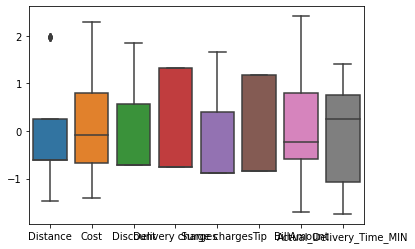

In [125]:
# Box plot of indep variables
sns.boxplot(data=swiggy_indep_numeric)

### Clearly outlier is seen in Distance column
**Other numeric columns have no outlier issue**

In [126]:
swiggy_indep_numeric['Distance'].describe()

count    5.500000e+01
mean     4.844610e-17
std      1.009217e+00
min     -1.479994e+00
25%     -6.140400e-01
50%     -6.140400e-01
75%      2.519138e-01
max      1.983822e+00
Name: Distance, dtype: float64

In [127]:
swiggy_indep_numeric['Distance'].value_counts()

-0.614040    34
 0.251914    10
 1.983822    10
-1.479994     1
Name: Distance, dtype: int64

**If we remove the outlier in Distance, we will lost 10 records.**                  
**We dont want to work with only 45 rows. So we retain all records - 55 in all**


## Correlation between predictors 

In [128]:
# Now we look at bivariate correlations assuming rating is continous
# We will input only continuous dep variables here for correlation check
# For discrtized/one-hot encoded dep variables, we will assume rating is discrete too and check chi-square value late

corr = swiggy_indep_numeric.corr()
corr.style.background_gradient(cmap='coolwarm')

,Distance,Cost,Discount,Delivery charges,Surge charges,Tip,BillAmount,Actual_Delivery_Time_MIN
Distance,1.000000,-0.001724,-0.080296,0.845029,0.383005,0.437007,0.053154,0.241085
Cost,-0.001724,1.000000,-0.070496,0.133280,0.203365,-0.262707,0.985279,0.339356
Discount,-0.080296,-0.070496,1.000000,-0.061612,-0.339461,0.001717,-0.227512,-0.030114
Delivery charges,0.845029,0.133280,-0.061612,1.000000,0.491304,0.125388,0.184251,0.551569
Surge charges,0.383005,0.203365,-0.339461,0.491304,1.000000,-0.088983,0.306646,0.295674
Tip,0.437007,-0.262707,0.001717,0.125388,-0.088983,1.000000,-0.239338,-0.500491
BillAmount,0.053154,0.985279,-0.227512,0.184251,0.306646,-0.239338,1.000000,0.349352
Actual_Delivery_Time_MIN,0.241085,0.339356,-0.030114,0.551569,0.295674,-0.500491,0.349352,1.000000


In [129]:
# Check correlations with Dependent variable Rating
swiggy_indep_numeric_withDep = swiggy[['Rating','Distance','Cost','Discount','Delivery charges','Surge charges','Tip','BillAmount','Actual_Delivery_Time_MIN']]
swiggy_indep_numeric_withDep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rating                    55 non-null     float64
 1   Distance                  55 non-null     float64
 2   Cost                      55 non-null     float64
 3   Discount                  55 non-null     float64
 4   Delivery charges          55 non-null     float64
 5   Surge charges             55 non-null     float64
 6   Tip                       55 non-null     float64
 7   BillAmount                55 non-null     float64
 8   Actual_Delivery_Time_MIN  55 non-null     float64
dtypes: float64(9)
memory usage: 4.3 KB


In [130]:
# Checking correlation of numeric conti variables with dep Rating
corr = swiggy_indep_numeric_withDep.corr()
corr.style.background_gradient(cmap='coolwarm')

,Rating,Distance,Cost,Discount,Delivery charges,Surge charges,Tip,BillAmount,Actual_Delivery_Time_MIN
Rating,1.000000,-0.620657,-0.029486,0.152794,-0.430246,-0.129265,-0.027843,-0.064900,-0.190196
Distance,-0.620657,1.000000,-0.001724,-0.080296,0.845029,0.383005,0.437007,0.053154,0.241085
Cost,-0.029486,-0.001724,1.000000,-0.070496,0.133280,0.203365,-0.262707,0.985279,0.339356
Discount,0.152794,-0.080296,-0.070496,1.000000,-0.061612,-0.339461,0.001717,-0.227512,-0.030114
Delivery charges,-0.430246,0.845029,0.133280,-0.061612,1.000000,0.491304,0.125388,0.184251,0.551569
Surge charges,-0.129265,0.383005,0.203365,-0.339461,0.491304,1.000000,-0.088983,0.306646,0.295674
Tip,-0.027843,0.437007,-0.262707,0.001717,0.125388,-0.088983,1.000000,-0.239338,-0.500491
BillAmount,-0.064900,0.053154,0.985279,-0.227512,0.184251,0.306646,-0.239338,1.000000,0.349352
Actual_Delivery_Time_MIN,-0.190196,0.241085,0.339356,-0.030114,0.551569,0.295674,-0.500491,0.349352,1.000000


# Conclusions from bivariate correlations

**1. Distance and delivery charges are highly correlated - one of these can be dropped         
2. We will retain Distance since it is more corrleated with Rating as compared to Delivery charge        
3. Cost and Bill Amount are highly correlated, one of these can be dropped .                    
4. However both Cost and BillAmount are poorly correlated with Dependent.  Both can be dropped.            
5. Top correlations with Rating are observed for: Distance, and weak correlation observed for Actual_Delivery_Time        
6. We can, for now, retain Distance, Actual_Delivery_Time and Discount for our model with Dep Rating**

    

# Categorical Variable Analysis: Top Categorical Predictors using Chi-Square

In [131]:
# ChisSquare Test for categorical 
# 1. For categorical variable, the above corrleations do not make sense, so we need to do chisquare test
# 2. We will assume rating is discrete while doing chi-square test

# Make DF containing only categorical discretized variables
# These variables are Status_New, PRO, NoPromoAval, BF, COD, CARD, WALLET, BING, BONG, NOMEMBERSHIP, VEG, MIX, NONVEG, PV-Y, PV-N

swiggy_indep_cat_withDep = swiggy[['Rating','Status_New','PRO','NoPromoAval','BF','COD','CARD','WALLET','BING','BONG', 'NOMEMBERSHIP','VEG','MIX','NON-VEG','PV-Y','PV-N']]
swiggy_indep_cat_withDep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rating        55 non-null     float64
 1   Status_New    55 non-null     int32  
 2   PRO           55 non-null     int32  
 3   NoPromoAval   55 non-null     int32  
 4   BF            55 non-null     int32  
 5   COD           55 non-null     int32  
 6   CARD          55 non-null     int32  
 7   WALLET        55 non-null     int32  
 8   BING          55 non-null     int32  
 9   BONG          55 non-null     int32  
 10  NOMEMBERSHIP  55 non-null     int32  
 11  VEG           55 non-null     int32  
 12  MIX           55 non-null     int32  
 13  NON-VEG       55 non-null     int32  
 14  PV-Y          55 non-null     int32  
 15  PV-N          55 non-null     int32  
dtypes: float64(1), int32(15)
memory usage: 4.1 KB


In [132]:
swiggy_indep_cat_only = swiggy[['Status_New','PRO','NoPromoAval','BF','COD','CARD','WALLET','BING','BONG', 'NOMEMBERSHIP','VEG','MIX','NON-VEG','PV-Y','PV-N']]
swiggy_indep_cat_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Status_New    55 non-null     int32
 1   PRO           55 non-null     int32
 2   NoPromoAval   55 non-null     int32
 3   BF            55 non-null     int32
 4   COD           55 non-null     int32
 5   CARD          55 non-null     int32
 6   WALLET        55 non-null     int32
 7   BING          55 non-null     int32
 8   BONG          55 non-null     int32
 9   NOMEMBERSHIP  55 non-null     int32
 10  VEG           55 non-null     int32
 11  MIX           55 non-null     int32
 12  NON-VEG       55 non-null     int32
 13  PV-Y          55 non-null     int32
 14  PV-N          55 non-null     int32
dtypes: int32(15)
memory usage: 3.7 KB


In [133]:
swiggy_dep_only = swiggy[['Rating']]
swiggy_dep_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rating  55 non-null     float64
dtypes: float64(1)
memory usage: 880.0 bytes


In [134]:
# Importing libraries
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [135]:
X = swiggy_indep_cat_only
y = swiggy_dep_only

In [136]:
y = y.astype(int)

In [137]:
X = X.astype(int)

In [138]:
# k = 7 tells 7 top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
test = SelectKBest(score_func=chi2, k=8)
fit = test.fit(X, y)
fit.scores_
fit.get_support()

array([ True, False, False,  True,  True,  True,  True, False,  True,
       False, False,  True, False, False,  True])

In [139]:
chi2_scores, p_values = chi2(X,y)
print("Chi-2 Scores",chi2_scores)
print("p values",p_values)
dfsupp=pd.DataFrame(fit.get_support())
dfcolumns=pd.DataFrame(X.columns)
dfscores=pd.DataFrame(fit.scores_)
Featurescores=pd.concat([dfcolumns,dfscores,dfsupp], axis=1)
Featurescores

Chi-2 Scores [13.25070028  9.82303114  4.97916667 16.01020408 16.3797123  29.28571429
 17.29109977  6.72802198 17.06364469  8.23028274  8.3578869  17.06364469
  6.92559524  8.3578869  11.62836439]
p values [2.11393474e-02 8.04077134e-02 4.18428012e-01 6.81500112e-03
 5.83958937e-03 2.03787751e-05 3.97955903e-03 2.41666079e-01
 4.38066140e-03 1.43992645e-01 1.37583615e-01 4.38066140e-03
 2.26232962e-01 1.37583615e-01 4.02505817e-02]


,0,0,0
0,Status_New,13.250700,True
1,PRO,9.823031,False
2,NoPromoAval,4.979167,False
3,BF,16.010204,True
4,COD,16.379712,True
5,CARD,29.285714,True
6,WALLET,17.291100,True
7,BING,6.728022,False
8,BONG,17.063645,True
9,NOMEMBERSHIP,8.230283,False


## Relation between each predictor and target

### Conclusions from ChiSq Test
**The following are found to be good predictors:  BF, COD,CARD ,WALLET, BONG ,MIX, Status_New.                
BONG and MIX have same Chi 2 value so dropping BONG**

### Based on correlations - higher correlation with Ratings is taken into 1st build of our model
**We retain Distance, Actual_Delivery_Time and Discount and Bill Amount for our model with Dep Rating**


<center><h1>Section 4: Feature selection and Modeling </h1></center>

<left><h3>from Correlation matrix for continous variables,we ended up with 3 features for model building. </h3></left>
<left><h3>from above chi 2 scores, we are considering 6 features with high scores for model buliding </h3></left>


### Initial model building with selected fetures from EDA sections

In [140]:
swiggy_Initial_Model = swiggy[['Rating','Distance','Discount','Actual_Delivery_Time_MIN','COD','CARD','WALLET','MIX','BF','Status_New']]
swiggy_Initial_Model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rating                    55 non-null     float64
 1   Distance                  55 non-null     float64
 2   Discount                  55 non-null     float64
 3   Actual_Delivery_Time_MIN  55 non-null     float64
 4   COD                       55 non-null     int32  
 5   CARD                      55 non-null     int32  
 6   WALLET                    55 non-null     int32  
 7   MIX                       55 non-null     int32  
 8   BF                        55 non-null     int32  
 9   Status_New                55 non-null     int32  
dtypes: float64(4), int32(6)
memory usage: 3.4 KB


In [141]:
x=swiggy_Initial_Model[['Distance','Discount','Actual_Delivery_Time_MIN','COD','CARD','WALLET','MIX','BF','Status_New']]
y=swiggy_Initial_Model['Rating']

In [142]:
import statsmodels.api as sm
x_alt = sm.add_constant(x)

In [143]:
x_alt.head()

,const,Distance,Discount,Actual_Delivery_Time_MIN,COD,CARD,WALLET,MIX,BF,Status_New
0,1.0,-0.614040,1.839698,0.247751,1,0,0,0,0,1
1,1.0,-0.614040,-0.721907,-1.081645,0,0,1,1,1,1
2,1.0,1.983822,0.558896,-0.749296,0,1,0,0,0,0
3,1.0,0.251914,-0.721907,1.410973,1,0,0,0,0,1
5,1.0,-0.614040,-0.721907,-1.746343,1,0,0,0,0,0


## Building a function for generating models and model stats is called get_stats
#### next step it will fit SM model on train data and generate coefficient estimates along with pvalue, and metrics like RSE, RMSE, RSq and detailed summary table for the fit.
#### Next, it does the same for the test data
#### Train = 35 datapoints and test = 20 data points
#### We used a hyperparameter of 0.646463 for test-train split. This was found to be the ideal test-train split based on nature of data and iterating using different test-train splits. Also we need to ensure at least 20 data points for test to compute the error statistics.

### Using the get_stats function , we will go through iteration to for back ward step wise elimiation of features and  building model 
### At each step, we will drop the predictor with the highest p-value - whos coefficient is not significant in the fit
### We will note model error and model performance on test data at each stage

In [144]:
x_columns = ["const","Distance","Discount","Actual_Delivery_Time_MIN","COD","CARD","WALLET","BF","MIX","Status_New"]

y = swiggy_Initial_Model["Rating"]

In [145]:
## creating function to get model statistics
import numpy as np
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import math

def get_stats():
    
    x = x_alt[x_columns]
    
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.636364, random_state = 100)
    
    
    #### Fit on train ####
    #x_train.info()
    results_train = sm.OLS(y_train, x_train).fit()
    print(results_train.summary())
    
    y_pred_train = results_train.predict(x_train)
    
    sm_rse_train = (35**2)*x_train.shape[0]
    sm_rse_train /= x_train.shape[0]-2
    print('sm_rse_train: ', sm_rse_train)
    
    sm_rmse_train = math.sqrt(mean_squared_error(y_pred_train, y_train))
    print('sm_rmse_train: ', sm_rmse_train)
    
    print('R squared_train (Variance score) = %.2f' % r2_score(y_train, y_pred_train))  
    print('Mean Absolute Error Train:', metrics.mean_absolute_error(y_train, y_pred_train))
    print('Mean Squared Error Train:', metrics.mean_squared_error(y_train, y_pred_train))
    print('Root Mean Squared Error Train:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    
    #### See perf on test ####
    #x_test.info()
    results_test = sm.OLS(y_test, x_test).fit()
    print(results_test.summary())
    
    y_pred_test = results_test.predict(x_test)
    
    sm_rse_test = (20**2)*x_test.shape[0]
    sm_rse_test /= x_test.shape[0]-2
    print('sm_rse_test: ', sm_rse_test)
    sm_rmse_test = math.sqrt(mean_squared_error(y_pred_test, y_test))
    print('sm_rmse_test: ', sm_rmse_test)
    
    
    print('R squared_test (Variance score) = %.2f' % r2_score(y_test, y_pred_test))   
    print('Mean Absolute Error Test:', metrics.mean_absolute_error(y_test, y_pred_test))
    print('Mean Squared Error Test:', metrics.mean_squared_error(y_test, y_pred_test))
    print('Root Mean Squared Error Test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
   
    
get_stats()

## From above regression results table, we see discount is having high P value so dropping thsi feature and mvoing through stepwise elimination 

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     16.10
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           2.84e-08
Time:                        18:03:41   Log-Likelihood:                -37.225
No. Observations:                  35   AIC:                             92.45
Df Residuals:                      26   BIC:                             106.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## Initial Model: Results & Conclusions
**The Inital model with 9 variables & a bias unit, ended up with  R2 value of 0.83 on train data, performance on test is R2 of .81 - train and test performance is comparable.
Based on pvalue, we see that several features have pvalue greater than 0.05.     
We start dropping features in the model based on performance based on p-value     
Highest pvalue is considered least useful predictor and is eliminated in the next iteration**


## Iteration 1: Remove "Actual_Delivery_Time_MIN"
**Model has 8 predictors and 1 bias unit    
Predictors included are:"Distance","Discount","COD","CARD","WALLET","BF","MIX","Status_New"**

In [146]:
x_columns.remove("Actual_Delivery_Time_MIN")
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     19.10
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           6.23e-09
Time:                        18:04:21   Log-Likelihood:                -37.238
No. Observations:                  35   AIC:                             90.48
Df Residuals:                      27   BIC:                             102.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4042      0.251      5.602      0.0

## Iteration1: Results & Conclusions
**The Iteration1 model with 8 variables & a bias unit, ended up with  R2 value of 0.83 on train data. Test performance is quantified by Rsquare of .76 which is lower than train, but does not indicate overfitting concerns at this point.    
Based on pvalue, we see that several features have pvalue greater than 0.05.     
We start dropping features in the model based on performance based on p-value     
Highest pvalue is considered least useful predictor and is eliminated in the next iteration**

## Iteration 2: Remove "CARD"
**Model has 7 predictors and 1 bais unit    
Predictors included are:"Distance","Discount","COD","WALLET","BF","MIX","Status_New"**

In [147]:
x_columns.remove("CARD")
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     19.10
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           6.23e-09
Time:                        18:04:51   Log-Likelihood:                -37.238
No. Observations:                  35   AIC:                             90.48
Df Residuals:                      27   BIC:                             102.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6270      1.057      1.539      0.1

## Iteration2: Results & Conclusions
**The Iteration 2 model with 7 variables & a bias unit, ended up with  R2 value of 0.832 on train data. Test data gives Rsquare of 0.76 which again is lower than train accuracy but does not give reason to worry about overfitting.   
Based on pvalue, we see that several features have pvalue greater than 0.05.     
We start dropping features in the model based on performance based on p-value     
Highest pvalue is considered least useful predictor and is eliminated in the next iteration**

## Iteration 3: Remove "COD"
**Model has 6 predictors and 1 bais unit    
Predictors included are:"Distance","Discount","WALLET","BF","MIX","Status_New"**

In [148]:
x_columns.remove("COD")
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     22.95
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           1.32e-09
Time:                        18:05:16   Log-Likelihood:                -37.336
No. Observations:                  35   AIC:                             88.67
Df Residuals:                      28   BIC:                             99.56
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2308      0.282      4.370      0.0

## Iteration3: Results & Conclusions
**The Iteration 3  with 6 variables & a bias unit, ended up with  R2 value of 0.83 on train data. Test data gives Rsquare of 0.74 and does not cause overfitting concerns.  
Based on pvalue, we see that several features have pvalue greater than 0.05.     
We start dropping features in the model based on performance based on p-value     
Highest pvalue is considered least useful predictor and is eliminated in the next iteration**

## Iteration 4: Remove "Discount"
**Model has 5 predictors and 1 bais unit    
Predictors included are:"Distance","Discount","Actual Delivery Time", "COD",,"WALLET","BONG","MIX","Status_New"**

In [149]:
x_columns.remove("Discount")
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     28.32
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           2.51e-10
Time:                        18:05:30   Log-Likelihood:                -37.438
No. Observations:                  35   AIC:                             86.88
Df Residuals:                      29   BIC:                             96.21
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2822      0.248      5.178      0.0

## Iteration4: Results & Conclusions
**The Iteration 4  with 5 variables & a bias unit, ended up with  R2 value of 0.832 on train data. Test accuracy is also reseonable at .70 Rsquare.     
At this Iteration, all pvalues for predictor varibles are less than 0.05 and all predictor coefficients are valid, strong and with the sign consistent with interpretaion from busines standpoint and also the direction of correlation .**

<center><h1>Final Model Explanation </h1></center>
<left><h2>Generalized model obtained with good accuracy</h2></left>
<left><h3>Rating = 1.28 + (-0.65* Distance) + (1.57* Wallet) + (1.80 * BF) + (-1.42 * MIX) + (1.17* Status_New) </h3></left>

#### Model has 5 predictor variables with accuracy of .70 on test data, while train has .83. These are good for a model to be considered viable.
#### All predictor variables in the model are significant: Distance is the continuous predictor variable impacting rating. Higher the distance, rating of the order is expected to be corrospondingly lower by a factor of 0.65 approximately
#### A 70% Rsquare on test shows that overfitting is not a big issue here. However, using only 35 data points on train and 20 for test limits our ability to comment on the extent of overfitting, if at all we have concerns.
#### Ideally for 6 variables, we expect to model on atleast 60 data point. Here we are using only 35 data rows for model building. As such, since test accuracy is in-line with train accuracy, it may be safe to say, in this scenario with only 35 rows, we dont see an overfiiting issue with the final model. Ideally, we would have preferred to do k-fold cross validation to completely satisfy ourself on the overfitting concern, but limited sample size does not support this.
### Interpretability is available below for the model and is good from a business standpoint also.

<left><h2>Comparision of model parameters with reference to the EDA</h2></left>


#### Distance - had a correlation of -0.62 with Rating from EDA
#### From the regression model, we observe a coefficent of -0.66 for distance, implying for every unit increase in distance, corrosponding Rating falls by a factor of 0.66 - this is in line with the negative correlation observed in EDA.

#### From EDA Chisquare for Wallet is 17.29. In our final model, the coefficent of Wallet is 1.57 and is significant. 
#### From EDA, Chisquare for BF, which is a promocode is 16.01. The model coefficient for the Promocode BF in the model is 1.8.  Usage of BF promocode implies a rating improvment by a factor of 1.8.

#### Chisquare for Mix is 17.06. Model coefficient is -1.42 implying that mixed order types have a rating decline of a factor of 1.42 compared to other order types.

#### Chisquare for Status_New is 13.25. Model coefficient is 1.17 implying that completed orders have a rating improvement by a factor of 1.47 compared cancelled orders.

## As such, this is a fine model from the model stats, error and interpretability perpespective. The performance on test data is also reasonable, implying no overfitting issues.